In [1]:
import os,time,sys,datetime,math
import numpy as np
import pandas as pd

root = '/Users/xindu/OneDrive/Data/UCI/Confemm/OnlineNewsPopularity/'
filename = 'OnlineNewsPopularity.csv'

path = os.path.join(root, filename)
df = pd.read_csv(path,sep=',')
N_d = df.shape[0]
print(N_d)

print(df.columns)
print(df.isna().sum())
print(df.head())

39644
Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' globa

In [2]:
df[' shares'] = df[' shares'].astype(np.int64)
# print(df[' shares'].min())
# df[' shares'] = df[' shares'].apply(lambda x: x if x<4000 else 4000)
df[' shares'] = pd.qcut(df[' shares'],
                        q=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                        labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

print(df[' shares'].value_counts())

 shares
2    4495
5    4362
3    4326
7    4005
0    3976
1    3953
9    3946
8    3862
6    3387
4    3332
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

Train = df.sample(frac=0.9)
Test = df.drop(Train.index)

# X = df.values[:,:-1].astype(np.float32)
# print(X.shape)
# y = df.values[:,-1].astype(np.int64)
# print(y.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)
X_train = Train.values[:,1:-1].astype(np.float32)
X_test = Test.values[:,1:-1].astype(np.float32)
Y_train = Train.values[:,-1].astype(np.int64)
Y_test = Test.values[:,-1].astype(np.int64)

print(X_train.shape)
print(Y_test.shape)

(35680, 59)
(3964,)


In [5]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

cls = GradientBoostingClassifier(random_state=0)
cls.fit(X_train, Y_train)
score = cls.score(X_test, Y_test)
print(score)

0.18037336024217962


(array([405.,   0.,   0.,   0.,   0., 403.,   0.,   0.,   0.,   0.,   0.,
        454.,   0.,   0.,   0.,   0., 426.,   0.,   0.,   0.,   0.,   0.,
        310.,   0.,   0.,   0.,   0., 482.,   0.,   0.,   0.,   0.,   0.,
        322.,   0.,   0.,   0.,   0., 366.,   0.,   0.,   0.,   0.,   0.,
        395.,   0.,   0.,   0.,   0., 401.]),
 array([0.  , 0.18, 0.36, 0.54, 0.72, 0.9 , 1.08, 1.26, 1.44, 1.62, 1.8 ,
        1.98, 2.16, 2.34, 2.52, 2.7 , 2.88, 3.06, 3.24, 3.42, 3.6 , 3.78,
        3.96, 4.14, 4.32, 4.5 , 4.68, 4.86, 5.04, 5.22, 5.4 , 5.58, 5.76,
        5.94, 6.12, 6.3 , 6.48, 6.66, 6.84, 7.02, 7.2 , 7.38, 7.56, 7.74,
        7.92, 8.1 , 8.28, 8.46, 8.64, 8.82, 9.  ]),
 <BarContainer object of 50 artists>)

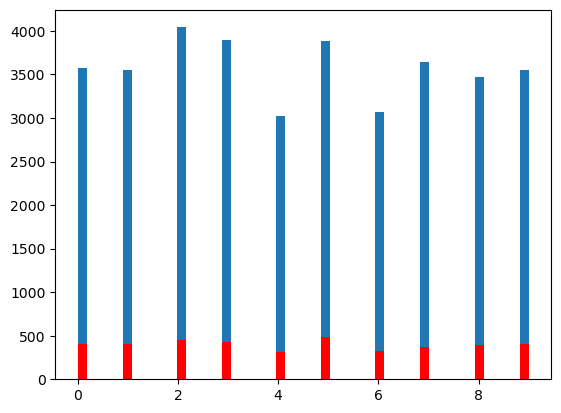

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
# print(df.values[:,-1].min())
ax.hist(Y_train, bins=50, density=False)
ax.hist(Y_test, bins=50, density=False, color='red')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class Classifier(nn.Module):
    def __init__(self, infea:int=11, hidden:int=50, out:int=10, *args, **kwargs):
        super(Classifier, self).__init__(*args, **kwargs)
        self.infea = infea
        self.hidden = hidden
        self.out = out
        self.encoder = nn.Sequential(
            nn.Linear(infea, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden*2),
            nn.BatchNorm1d(hidden*2),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4, hidden*4),
            nn.BatchNorm1d(hidden*4),
            nn.ReLU(),
        )
        self.final = nn.Linear(hidden*4, out)

    def forward(self, x: Tensor):
        h = self.encoder(x)
        logits = self.final(h)
        return logits

In [6]:
import copy
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from typing import Any, Optional, OrderedDict, List
from collections import defaultdict

def train(dataset: Optional[dict], model: nn.Module, optimizer: Optional[Any], scheduler: Optional[Any],
          epoch: int=100, batch_size: int=128, device: str='cpu'):
    trainloss = defaultdict(list)
    testloss = defaultdict(list)

    X_train, X_test, y_train, y_test = dataset['train_x'], dataset['test_x'], dataset['train_y'], dataset['test_y']
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epoch):
        print("epoch: " + str(epoch) + '===================================================')
        n_train = X_train.shape[0]
        n_test = X_test.shape[0]
        if epoch == 0:
            print(f'train length: {n_train}, test length: {n_test}')

        I = list(range(0, n_train))
        
        running_loss = 0.0
        running_test_loss = 0.0
        running_corrects = 0
        running_test_corrects = 0

        model.train()
        for i_batch in range(n_train // batch_size):
            if i_batch < (n_train // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_train[I_b, :]
            y_batch = y_train[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)

            # print(y_batch)

            with torch.set_grad_enabled(True):
                logits = model(x_batch)
                loss = torch.nn.functional.cross_entropy(logits, y_batch)
                _, preds = torch.max(logits, 1)
                corrects = torch.sum(preds == y_batch.data)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                trainloss['loss'].append(loss.item())
                running_loss += loss.item() * x_batch.size(0)
                running_corrects +=  corrects.item()
                acc = corrects.item()*1.0/x_batch.size(0)
                trainloss['running acc'].append(acc)

            if i_batch > 0 and i_batch % 500 == 0:
                print(f'ibatch: {i_batch}, train loss: {loss}, train acc: {acc}.')
        
        epoch_loss = running_loss / n_train
        epoch_acc = running_corrects * 1.0 / n_train
        
        trainloss['epoch'].append(epoch_loss)
        trainloss['epoch_acc'].append(epoch_acc)

        I = list(range(0, n_test))
        model.eval()
        for i_batch in range(n_test // batch_size):
            if i_batch < (n_test // batch_size - 1):
                I_b = I[i_batch * batch_size:(i_batch+1) * batch_size]
            else:
                I_b = I[i_batch * batch_size:]
            x_batch = X_test[I_b, :]
            y_batch = y_test[I_b]

            x_batch = torch.from_numpy(x_batch).to(torch.float32).to(device)
            y_batch = torch.from_numpy(y_batch).to(torch.int64).to(device)

            with torch.set_grad_enabled(False):
                logits = model(x_batch)
                loss = torch.nn.functional.cross_entropy(logits, y_batch)
                _, preds = torch.max(logits, 1)
                corrects = torch.sum(preds == y_batch.data)
                
                testloss['loss'].append(loss.item())
                running_test_loss += loss.item()*x_batch.size(0)
                running_test_corrects += corrects.item()
                acc = corrects.item() * 1.0 / x_batch.size(0)
                testloss['acc'].append(acc)
                
        epoch_test_loss = running_test_loss / n_test
        epoch_acc = running_test_corrects * 1.0 / n_test
                
        testloss['epoch'].append(epoch_test_loss)
        testloss['epoch_acc'].append(epoch_acc)

        print(f'test loss: {epoch_test_loss}, test acc: {epoch_acc}.')

    time_elapsed = time.time() - since
    print(("Training complete in %sm %ss" % (time_elapsed // 60, time_elapsed % 60)))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    #         'scheduler_state_dict': scheduler.state_dict(),
        'trainloss': trainloss,
        'testloss': testloss,
        }, 'model_final')
    return model, trainloss, testloss

In [7]:
device = 'cpu'

datasets = dict()
datasets['train_x'] = X_train
datasets['test_x'] = X_test
datasets['train_y'] = Y_train
datasets['test_y'] = Y_test

model = Classifier(infea=59).to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

model, trainloss, valloss = train(dataset=datasets, model=model, optimizer=optimizer, 
                                  scheduler=scheduler, epoch=50, batch_size=128)

epoch: 0===================================================
train length: 35680, test length: 3964
test loss: 2.258717119272734, test acc: 0.15136226034308778.
epoch: 1===================================================
test loss: 2.2766339016249395, test acc: 0.14228052472250252.
epoch: 2===================================================
test loss: 2.2771689764305756, test acc: 0.14253279515640768.
epoch: 3===================================================
test loss: 2.2612244021880517, test acc: 0.14984863773965693.
epoch: 4===================================================
test loss: 2.267462649090379, test acc: 0.1460645812310797.
epoch: 5===================================================
test loss: 2.2820825444461117, test acc: 0.1284056508577195.
epoch: 6===================================================
test loss: 2.288753804958432, test acc: 0.12386478304742685.
epoch: 7===================================================
test loss: 2.269365520939216, test acc: 0.1289101917

tensor([[0.8249, 0.9132, 0.9129,  ..., 0.8773, 0.9203, 0.9467],
        [0.8209, 0.9128, 0.9129,  ..., 0.8781, 0.9209, 0.9473],
        [0.8130, 0.9120, 0.9129,  ..., 0.8797, 0.9220, 0.9485],
        ...,
        [0.8857, 0.8638, 0.8630,  ..., 0.9125, 0.9310, 0.9482],
        [0.8017, 0.7978, 0.8331,  ..., 0.9470, 0.9603, 0.9727],
        [0.7982, 0.7970, 0.8332,  ..., 0.9479, 0.9604, 0.9729]],
       grad_fn=<RsubBackward1>)
3964


(array([  1.,   7.,  86., 247., 383., 690., 850., 995., 535., 170.]),
 array([0.73248351, 0.75663522, 0.78078693, 0.80493864, 0.82909036,
        0.85324207, 0.87739378, 0.90154549, 0.92569721, 0.94984892,
        0.97400063]),
 <BarContainer object of 10 artists>)

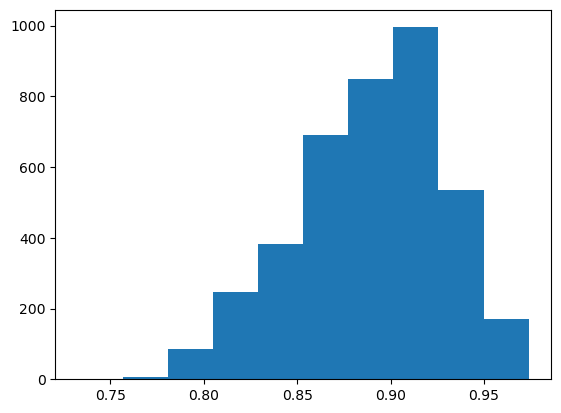

In [8]:
x_test = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test = torch.from_numpy(Y_test).to(torch.int64).to(device)

x_train = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train = torch.from_numpy(Y_train).to(torch.int64).to(device)

sfs = 1-model(x_test).softmax(dim=1)
print(sfs)
scores = []
for i in range(sfs.shape[0]):
    scores.append(sfs[i][y_test[i]].item())

print(len(scores))
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(scores, density=False)

In [9]:
alpha = 0.1
n = len(scores)
qalpha = np.ceil((n+1)*(1-alpha))/n
print(qalpha)
qhat = torch.quantile(torch.tensor(np.array(scores)), torch.tensor(qalpha))
print(qhat)

0.9003531786074672
tensor(0.9366, dtype=torch.float64)


3964
avg cov: 0.898520
avg cov: 0.899688


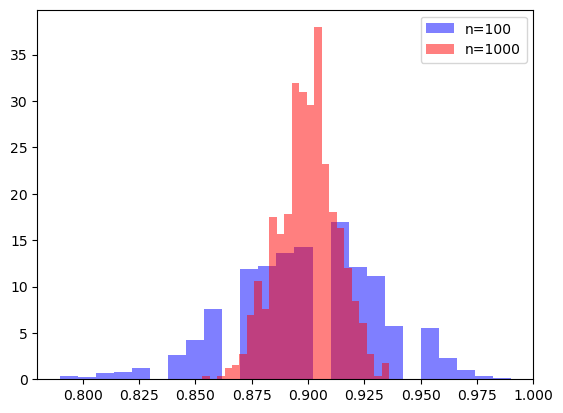

In [10]:
R = 1000
print(n)
alpha=0.1
scores_ = torch.tensor(scores)
coverages = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(3964)]
    calib_scores, val_scores = (scores__[:1000], scores__[3864:])
    qhat_ = torch.quantile(calib_scores, np.ceil((n+1)*(1-alpha))/n)
    coverages[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages.mean()
print('avg cov: %f' % average_coverage)

coverages2 = torch.zeros((R,))
for r in range(R):
    scores__ = scores_[torch.randperm(3964)]
    calib_scores, val_scores = (scores__[:1000], scores__[2964:])
    # print(calib_scores.mean())
    qalpha = np.ceil((n+1)*(1-alpha))/n
    # print(qalpha)
    qhat_ = torch.quantile(calib_scores, qalpha)
    # print(qhat_)
    coverages2[r] = (val_scores <= qhat_).float().mean()
average_coverage = coverages2.mean()
print('avg cov: %f' % average_coverage)
plt.hist(coverages,bins=25,density=True,label='n=100', color='blue', alpha=0.5)
plt.hist(coverages2,bins=25,density=True,label='n=1000', color='red', alpha=0.5)
plt.legend()

tensor([0.1786, 0.1887, 0.1624, 0.1248, 0.0736, 0.0875, 0.0482, 0.0597, 0.0449,
        0.0315], grad_fn=<SelectBackward0>)
tensor(6)
[6, 9, 10, 6, 6, 9, 10, 6, 10, 10, 9, 9, 6, 8, 10, 6, 6, 7, 6, 10, 10, 10, 9, 10, 10, 7, 6, 10, 10, 7, 7, 9, 9, 6, 6, 7, 7, 7, 6, 9, 10, 10, 9, 9, 7, 7, 9, 10, 7, 6, 6, 10, 9, 9, 10, 10, 7, 7, 7, 10, 9, 10, 9, 10, 7, 8, 8, 9, 7, 7, 10, 6, 8, 6, 10, 10, 8, 6, 10, 8, 10, 8, 6, 7, 9, 9, 9, 10, 10, 7, 10, 7, 6, 10, 8, 7, 9, 10, 10, 9, 10, 10, 10, 10, 9, 6, 10, 9, 10, 7, 10, 6, 10, 9, 10, 9, 10, 7, 6, 6, 10, 9, 7, 10, 6, 9, 9, 6, 10, 6, 10, 10, 9, 10, 7, 10, 9, 10, 8, 10, 10, 10, 9, 7, 6, 9, 7, 8, 10, 10, 9, 9, 7, 9, 10, 6, 10, 7, 8, 9, 7, 7, 9, 6, 7, 7, 7, 10, 7, 8, 10, 10, 10, 9, 10, 6, 7, 7, 6, 6, 7, 7, 7, 9, 10, 10, 8, 9, 10, 9, 9, 10, 9, 10, 6, 7, 6, 10, 10, 7, 10, 7, 9, 9, 10, 7, 9, 10, 7, 9, 9, 9, 9, 10, 7, 9, 9, 9, 10, 9, 9, 9, 6, 9, 10, 10, 9, 9, 9, 7, 6, 7, 7, 10, 6, 10, 6, 10, 6, 7, 9, 9, 6, 9, 10, 6, 10, 9, 10, 7, 6, 9, 10, 10, 7, 9, 6, 10, 10, 10

(array([   16.,     0.,  6658.,     0.,  6479.,     0.,  1572.,     0.,
         8582., 12373.]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 10 artists>)

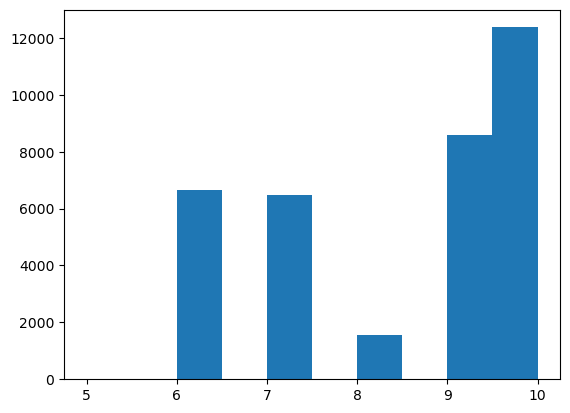

In [11]:
x_train = torch.from_numpy(X_train).to(torch.float32).to(device)

sms = model(x_train).softmax(dim=1)
print(sms[0])
prediction_sets = (sms > (1-qhat))
print(torch.sum(prediction_sets[0]))
sets = []
for i in range(sms.shape[0]):
    sets.append(torch.sum(prediction_sets[i]).to(torch.int64).item())
print(sets)
fig, ax = plt.subplots(1, 1)
# ax.fill_between(I, 0, probs)
ax.hist(sets, density=False)

In [12]:
import os
import sys
sys.path.append(os.getcwd())
import pandas as pd
import numpy as np
from numpy import linalg as LA
import heapq

key_labels = {}
#
def as_string(desc):
    return ' and '.join(desc)

def satisfies_all(desc,df,N):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    cover_desc = sum(ind)
    return (cover_desc / N > 0.0001 and cover_desc / N < 0.5)

class BoundedPriorityQueue:
    """
    Ensures uniqness
    Keeps a maximum size (throws away value with least quality)
    """

    def __init__(self, bound, df):
        self.values = []
        self.bound = bound
        self.entry_count = 0
        self.df = df

    def desc_intersect(self, desc1, coverage, desc2, c):
        ind_new = self.df.eval(as_string(desc1))
        ind_old = self.df.eval(as_string(desc2))
        if coverage*0.9 > c:
            return False
        if (ind_new & ind_old).sum() > c*0.8:
            return True
        return False

    def add(self, element, quality, coverage):
        if any((e == element for (_, _, e, _) in self.values)):
            return  # avoid duplicates

        # if any((self.desc_intersect(element, coverage, e, c) for (_,_,e,c) in self.values)):
        #     return        

        new_entry = (quality, self.entry_count, element, coverage)
        if (len(self.values) >= self.bound):
            temp=heapq.heappushpop(self.values, new_entry)
        else:
            heapq.heappush(self.values, new_entry)

        self.entry_count += 1

    def get_values(self):
        for (q, _, e, coverage) in sorted(self.values, reverse=True):
            yield (e, q, coverage)

    def out_vectors(self):
        return [q for (q, _, _, _) in sorted(self.values, reverse=True)]

    def show_contents(self):  # for debugging
        print("show_contents")
        for (q, entry_count, e, coverage) in self.values:
            # print(q, entry_count, e)
            print("quality: %f, entry: %d, element: %s, coverage: %f" % (q, entry_count, e, coverage))

#
class Queue:
    """
    Ensures uniqness
    """

    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def enqueue(self, item):
        if item not in self.items:
            self.items.insert(0, item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

    def get_values(self):
        return self.items

    def add_all(self, iterable):
        for item in iterable:
            self.enqueue(item)

    def clear(self):
        self.items.clear()

In [18]:
def refine(desc, more):
    copy = desc[:]
    copy.append(more)
    return copy

def eta(seed,fs,df):
    for f in fs:
        column_data = df[f]
        if (df[f].dtype == 'float32'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {value:.3f}".format(f, value=x)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'object'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'int64'):
            min_val, max_val = min(column_data), max(column_data)
            for x in np.linspace(min_val, max_val, 10):
                candidate = "{} <= {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} > {}".format(f, np.floor(x))
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
        elif (df[f].dtype == 'bool'):
            uniq = column_data.dropna().unique()
            for i in uniq:
                candidate = "{} == '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)
                candidate = "{} != '{}'".format(f, i)
                if not candidate in seed: # if not already there
                    yield refine(seed, candidate)                    
        else:
            assert False

def varphi_ent(d,n):
    return np.sqrt(-(d/n)*np.log2(d/n) - ((n-d)/n)*np.log2((n-d)/n))

def eval_quality(desc, model, df, mu_omega):
    d_str = as_string(desc)
    ind = df.eval(d_str)
    df_sd = df.loc[ind]
    
    x_sd = df_sd.values[:, :-1].astype(np.float32)
    x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)
    sms = model(x_sd).softmax(dim=1)
    predictions_sets = (sms > 1-qhat)
    sets_sd = []
    for i in range(sms.shape[0]):
        sets_sd.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
    mu_sd = np.mean(sets_sd)
    quality = mu_sd - mu_omega
    # quality = mu_omega - mu_sd

    coverage = sum(ind) / df.shape[0]
    # ent = varphi_ent(sum(ind), df.shape[0])
    return quality, coverage

def EMM(df, fs, model, w, d, q, eta, satisfies_all, eval_quality):
    """
    w - width of beam
    d - num levels
    q - max results
    eta - a function that receives a description and returns all possible refinements
    satisfies_all - a function that receives a description and verifies wheather it satisfies some requirements as needed
    eval_quality - returns a quality for a given description. This should be comparable to qualities of other descriptions
    catch_all_description - the equivalent of True, or all, as that the whole dataset shall match
    """
    N = df.shape[0]

    x_omega = df.values[:, :-1].astype(np.float32)
    x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)
    sms = model(x_omega).softmax(dim=1)
    # print(sms[0])
    prediction_sets = (sms > (1-qhat))
    # print(torch.sum(prediction_sets[0]))
    sets_omega = []
    for i in range(sms.shape[0]):
        sets_omega.append(torch.sum(prediction_sets[i]).to(torch.int64).item())
    # print(sets)
    mu_omega = np.mean(sets_omega)
    print('mu omega: %f' % mu_omega)
                
    resultSet = BoundedPriorityQueue(q,df)
    candidateQueue = Queue()
    candidateQueue.enqueue([])
    for level in range(d):
        print("level : %d" % level)
        beam = BoundedPriorityQueue(w,df)
        for seed in candidateQueue.get_values():
            print("seed : %s" % str(seed))
            for desc in eta(seed, fs, df):
                if satisfies_all(desc,df,N):
                    quality, coverage = eval_quality(desc, model, df, mu_omega)
                    resultSet.add(desc, quality, coverage)
                    beam.add(desc, quality, coverage)
        beam.show_contents()
        #candidateQueue.clear()
        candidateQueue = Queue()
        candidateQueue.add_all(desc for (desc, _, _) in beam.get_values())
    return resultSet


In [15]:
Train['timedelta'] = Train[' timedelta'].astype(np.float32)
Train['n_tokens_title'] = Train[' n_tokens_title'].astype(np.float32)
Train['n_tokens_content'] = Train[' n_tokens_content'].astype(np.float32)
Train['n_unique_tokens'] = Train[' n_unique_tokens'].astype(np.float32)
Train['n_non_stop_words'] = Train[' n_non_stop_words'].astype(np.float32)
Train['n_non_stop_unique_tokens'] = Train[' n_non_stop_unique_tokens'].astype(np.float32)
Train['num_hrefs'] = Train[' num_hrefs'].astype(np.float32)
Train['num_self_hrefs'] = Train[' num_self_hrefs'].astype(np.float32)
Train['num_imgs'] = Train[' num_imgs'].astype(np.float32)
Train['num_videos'] = Train[' num_videos'].astype(np.float32)
Train['average_token_length'] = Train[' average_token_length'].astype(np.float32)
Train['num_keywords'] = Train[' num_keywords'].astype(np.float32)
Train['data_channel_is_lifestyle'] = Train[' data_channel_is_lifestyle'].astype(np.float32)
Train['data_channel_is_entertainment'] = Train[' data_channel_is_entertainment'].astype(np.float32)
Train['data_channel_is_bus'] = Train[' data_channel_is_bus'].astype(np.float32)
Train['data_channel_is_socmed'] = Train[' data_channel_is_socmed'].astype(np.float32)
Train['data_channel_is_tech'] = Train[' data_channel_is_tech'].astype(np.float32)
Train['data_channel_is_world'] = Train[' data_channel_is_world'].astype(np.float32)
Train['kw_min_min'] = Train[' kw_min_min'].astype(np.float32)
Train['kw_max_min'] = Train[' kw_max_min'].astype(np.float32)
Train['kw_avg_min'] = Train[' kw_avg_min'].astype(np.float32)
Train['kw_min_max'] = Train[' kw_min_max'].astype(np.float32)
Train['kw_max_max'] = Train[' kw_max_max'].astype(np.float32)
Train['kw_avg_max'] = Train[' kw_avg_max'].astype(np.float32)
Train['kw_min_avg'] = Train[' kw_min_avg'].astype(np.float32)
Train['kw_max_avg'] = Train[' kw_max_avg'].astype(np.float32)
Train['kw_avg_avg'] = Train[' kw_avg_avg'].astype(np.float32)
Train['self_reference_min_shares'] = Train[' self_reference_min_shares'].astype(np.float32)
Train['self_reference_max_shares'] = Train[' self_reference_max_shares'].astype(np.float32)
Train['self_reference_avg_sharess'] = Train[' self_reference_avg_sharess'].astype(np.float32)
Train['weekday_is_monday'] = Train[' weekday_is_monday'].astype(np.float32)
Train['weekday_is_tuesday'] = Train[' weekday_is_tuesday'].astype(np.float32)
Train['weekday_is_wednesday'] = Train[' weekday_is_wednesday'].astype(np.float32)
Train['weekday_is_thursday'] = Train[' weekday_is_thursday'].astype(np.float32)
Train['weekday_is_friday'] = Train[' weekday_is_friday'].astype(np.float32)
Train['weekday_is_saturday'] = Train[' weekday_is_saturday'].astype(np.float32)
Train['weekday_is_sunday'] = Train[' weekday_is_sunday'].astype(np.float32)
Train['is_weekend'] = Train[' is_weekend'].astype(np.float32)
Train['LDA_00'] = Train[' LDA_00'].astype(np.float32)
Train['LDA_01'] = Train[' LDA_01'].astype(np.float32)
Train['LDA_02'] = Train[' LDA_02'].astype(np.float32)
Train['LDA_03'] = Train[' LDA_03'].astype(np.float32)
Train['LDA_04'] = Train[' LDA_04'].astype(np.float32)
Train['global_subjectivity'] = Train[' global_subjectivity'].astype(np.float32)
Train['global_sentiment_polarity'] = Train[' global_sentiment_polarity'].astype(np.float32)
Train['global_rate_positive_words'] = Train[' global_rate_positive_words'].astype(np.float32)
Train['global_rate_negative_words'] = Train[' global_rate_negative_words'].astype(np.float32)
Train['rate_positive_words'] = Train[' rate_positive_words'].astype(np.float32)
Train['rate_negative_words'] = Train[' rate_negative_words'].astype(np.float32)
Train['avg_positive_polarity'] = Train[' avg_positive_polarity'].astype(np.float32)
Train['min_positive_polarity'] = Train[' min_positive_polarity'].astype(np.float32)
Train['max_positive_polarity'] = Train[' max_positive_polarity'].astype(np.float32)
Train['avg_negative_polarity'] = Train[' avg_negative_polarity'].astype(np.float32)
Train['min_negative_polarity'] = Train[' min_negative_polarity'].astype(np.float32)
Train['max_negative_polarity'] = Train[' max_negative_polarity'].astype(np.float32)
Train['title_subjectivity'] = Train[' title_subjectivity'].astype(np.float32)
Train['title_sentiment_polarity'] = Train[' title_sentiment_polarity'].astype(np.float32)
Train['abs_title_subjectivity'] = Train[' abs_title_subjectivity'].astype(np.float32)
Train['abs_title_sentiment_polarity'] = Train[' abs_title_sentiment_polarity'].astype(np.float32)


In [19]:
features = ['timedelta', 'n_tokens_title', 'n_tokens_content', 
			'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
			'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
			'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
			'data_channel_is_entertainment', 'data_channel_is_bus',
			'data_channel_is_socmed', 'data_channel_is_tech',
			'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
			'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
			'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
			'self_reference_max_shares', 'self_reference_avg_sharess',
			'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
			'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
			'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02',
			'LDA_03', 'LDA_04', 'global_subjectivity',
			'global_sentiment_polarity', 'global_rate_positive_words',
			'global_rate_negative_words', 'rate_positive_words',
			'rate_negative_words', 'avg_positive_polarity',
			'min_positive_polarity', 'max_positive_polarity',
			'avg_negative_polarity', 'min_negative_polarity',
			'max_negative_polarity', 'title_subjectivity',
			'title_sentiment_polarity', 'abs_title_subjectivity',
			'abs_title_sentiment_polarity']

print("features: %s" % features)

# dff = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
dff = Train[['timedelta', 'n_tokens_title', 'n_tokens_content', 
			'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
			'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
			'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
			'data_channel_is_entertainment', 'data_channel_is_bus',
			'data_channel_is_socmed', 'data_channel_is_tech',
			'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
			'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
			'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
			'self_reference_max_shares', 'self_reference_avg_sharess',
			'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
			'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
			'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02',
			'LDA_03', 'LDA_04', 'global_subjectivity',
			'global_sentiment_polarity', 'global_rate_positive_words',
			'global_rate_negative_words', 'rate_positive_words',
			'rate_negative_words', 'avg_positive_polarity',
			'min_positive_polarity', 'max_positive_polarity',
			'avg_negative_polarity', 'min_negative_polarity',
			'max_negative_polarity', 'title_subjectivity',
			'title_sentiment_polarity', 'abs_title_subjectivity',
			'abs_title_sentiment_polarity', ' shares']]
dff = dff.astype(np.float32)

EMM_res = EMM(df=dff, fs=features, model=model, w=20, d=2, q=10, eta=eta, satisfies_all=satisfies_all, eval_quality=eval_quality)

for (desc, quality, coverage) in EMM_res.get_values():
	print("{};{};{}\n".format(desc,quality,coverage))

features: ['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity'

5


Text(0.5, 1.0, 'self_reference_max_shares > 562200.000 and self_reference_avg_sharess <= 76711.111\n score subgroup: 10.000, score whole data: 8.621')

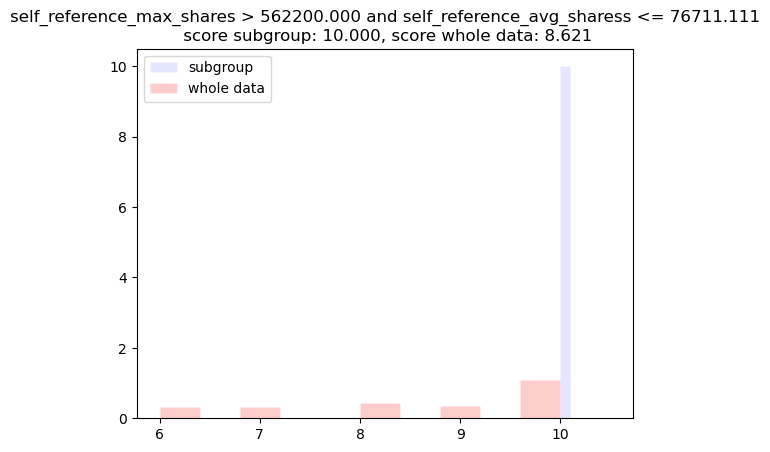

In [24]:
d_str = as_string(['self_reference_max_shares > 562200.000', 'self_reference_avg_sharess <= 76711.111'])
ind = dff.eval(d_str)
df_sd = dff.loc[ind]

x_sd = df_sd.values[:, :-1].astype(np.float32)
x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)
sms = model(x_sd).softmax(dim=1)
predictions_sets = (sms > 1-qhat)
sets_sd = []
for i in range(sms.shape[0]):
    sets_sd.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
print(len(sets_sd))

x_omega = dff.values[:, :-1].astype(np.float32)
x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)
sms = model(x_omega).softmax(dim=1)
# print(sms[0])
prediction_sets = (sms > (1-qhat))
# print(torch.sum(prediction_sets[0]))
sets_omega = []
for i in range(sms.shape[0]):
    sets_omega.append(torch.sum(prediction_sets[i]).to(torch.int64).item())

fig, ax = plt.subplots(1, 1)
preds_sd = sets_sd
preds_wd = sets_omega
ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
plt.legend()

score_sd = np.mean(sets_sd)
score_all = np.mean(sets_omega)

ax.set_title(f'{d_str}\n score subgroup: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')

['LDA_04 > 0.927', 'abs_title_sentiment_polarity <= 1.000'];1.6220571748878925;0.00011210762331838565

4
['LDA_04 > 0.927', 'abs_title_sentiment_polarity > 0.333'];1.6220571748878925;0.00011210762331838565

4
3
4
5
['LDA_04 > 0.927', 'abs_title_subjectivity <= 0.500'];1.6220571748878925;0.00011210762331838565

4
7
['LDA_04 > 0.927', 'abs_title_subjectivity <= 0.389'];1.6220571748878925;0.00011210762331838565

4
['LDA_04 > 0.927', 'abs_title_subjectivity <= 0.333'];1.6220571748878925;0.00011210762331838565

4
10
11435


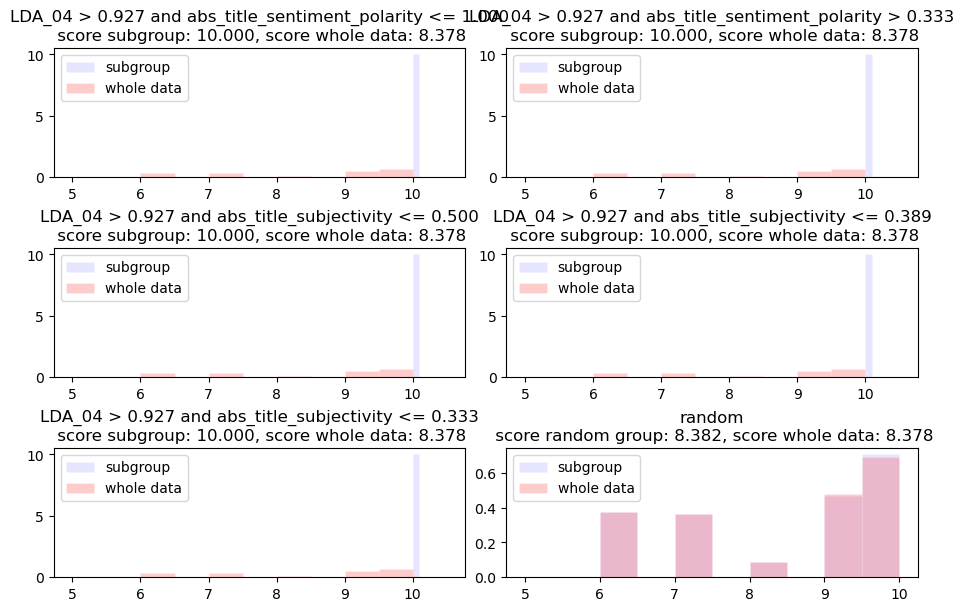

In [20]:
N_dff = dff.shape[0]

x_omega = dff.values[:, :-1].astype(np.float32)
x_omega = torch.from_numpy(x_omega).to(torch.float32).to(device)
sms = model(x_omega).softmax(dim=1)
# print(sms[0])
prediction_sets = (sms > (1-qhat))
# print(torch.sum(prediction_sets[0]))
sets_omega = []
for i in range(sms.shape[0]):
    sets_omega.append(torch.sum(prediction_sets[i]).to(torch.int64).item())

k = 0
q = 5
fig, axs = plt.subplots(3, 2, figsize=(9, 6), layout='constrained')

kk = [0,1,5,7,8]

for (desc, quality, coverage) in EMM_res.get_values():
	if k not in kk:
		k+=1
		print(k)
		continue
	print("{};{};{}\n".format(desc, quality, coverage))
	d_str = as_string(desc)
	ind = dff.eval(d_str)
	df_sd = dff.loc[ind]

	x_sd = df_sd.values[:, :-1].astype(np.float32)
	x_sd = torch.from_numpy(x_sd).to(torch.float32).to(device)
	sms = model(x_sd).softmax(dim=1)
	predictions_sets = (sms > 1-qhat)
	sets_sd = []
	for i in range(sms.shape[0]):
		sets_sd.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
	print(len(sets_sd))

	ax = axs.flat[kk.index(k)]
	if ax is None:
		ax = plt.gca()

	preds_sd = sets_sd
	preds_wd = sets_omega
	ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
	ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
	score_sd = np.mean(sets_sd)
	score_all = np.mean(sets_omega)
	ax.set_title(f'{d_str}\n score subgroup: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')
	ax.legend()
	k += 1
	

inds_rand = np.random.permutation(N_dff)
flag = np.random.randint(np.int32(0.2*N_dff), np.int32(0.5*N_dff))
inds_rand = inds_rand[:flag]
inputs = dff.iloc[inds_rand]

x_rand = inputs.values[:, :-1].astype(np.float32)
x_rand = torch.from_numpy(x_rand).to(torch.float32).to(device)
sms = model(x_rand).softmax(dim=1)
predictions_sets = (sms > 1-qhat)
sets_rand = []
for i in range(sms.shape[0]):
	sets_rand.append(torch.sum(predictions_sets[i]).to(torch.int64).item())
print(len(sets_rand))
ax = axs.flat[5]
preds_sd = sets_rand
preds_wd = sets_omega
ax.hist(preds_sd, linewidth=0.5, edgecolor="white", color='b', alpha=0.1, label='subgroup', density=True)
ax.hist(preds_wd, linewidth=0.5, edgecolor="white", color='r', alpha=0.2, label='whole data', density=True)
score_sd = np.mean(sets_rand)
score_all = np.mean(sets_omega)
ax.set_title(f'{'random'}\n score random group: {(score_sd):<0.3f}, score whole data: {(score_all):<0.3f}')
ax.legend()

